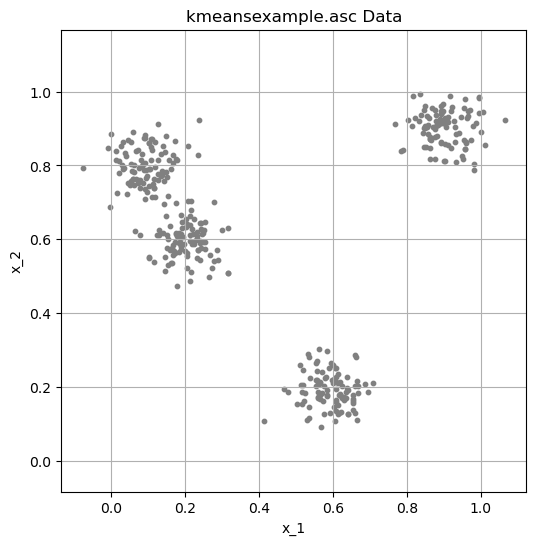

In [1]:
### problem 1 & 2 code
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

file_path = "/Users/adityamittal/Desktop/final/kmeansexample.asc"  
data = np.loadtxt(file_path)  

# plot raw data
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], s=10, color='grey')
plt.title("kmeansexample.asc Data")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.grid(True)
plt.axis("equal")
plt.show()

In [2]:
### I initially created a non-private version of this K-Means class for STA 142B 
### Assignment 2 by professor Wolgang Polonik.
### This class template allowed me to easily add noise to cluster sums and counts without redoing 
### all the code for k-means logic. I added necessary functions to add noise as needed.
### Comments will help tell where privacy is being added and what's happening. 
### I show results for all privacy variations.

class KMeansClustering:

    def __init__(self, data: np.ndarray, d: int, k: int, tol: float, max_iter: int,
                 private: bool = False, epsilon: float = 1.0, delta: float = 1/data.shape[0],
                 private_mechanism: str = 'laplace', seed: int = 20):
        """
        Clustering class for both private and non-private K-Means.
        private_mechanism: 'laplace' for eps-DP, 'gaussian' for (eps, delta)-DP
        """
        self.data = data
        self.d = d
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        self.n = data.shape[0]
        self.seed = seed
        self.private = private
        self.epsilon = epsilon
        self.delta = delta
        self.private_mechanism = private_mechanism.lower()
        self.partitions = {i: [] for i in range(k)}
        self.centers = np.zeros((k, d))
        self.next_centers = np.zeros((k, d))
        self.labels = np.array([])
        self.counter = 0

        # split privacy budget for iterations
        if private:
            self.eps_prime = self.epsilon / (2 * self.max_iter)
            self.delta_prime = self.delta / (2 * self.max_iter)
            np.random.seed(self.seed)
    
    def initialize_centers(self, method: int = 1):
        if method == 0:
            self.centers = self.data[:self.k, :]
        # random intialization of k centers as data points
        elif method == 1:
            np.random.seed(self.seed)
            self.centers = self.data[np.random.choice(self.n, self.k, replace=False), :]

    # includes both private and non-private versions
    def search(self):
        self.partitions = {i: [] for i in range(self.k)}
        self.next_centers = np.zeros((self.k, self.d))

        # setup
        for i in range(self.n):
            distances = np.linalg.norm(self.data[i] - self.centers, ord=2, axis=1)
            label = np.argmin(distances)
            self.partitions[label].append(i)

        for j in self.partitions:
            indices = np.array(self.partitions[j], dtype=int)
            if indices.size == 0:
                self.next_centers[j] = self.centers[j]
                continue

            # non-private counts
            Cj = len(indices)
            sum_j = np.sum(self.data[indices, :], axis=0)

            if self.private:
                if self.private_mechanism == 'laplace':
                    # eps-DP with laplace noise
                    scale = 1 / self.eps_prime
                    noisy_Cj = Cj + np.random.laplace(loc=0.0, scale=scale)
                    noisy_sum_j = sum_j + np.random.laplace(loc=0.0, scale=scale, size=self.d)
                elif self.private_mechanism == 'gaussian':
                    # (eps, delta)-DP with gaussian noise
                    sigma = np.sqrt(2 * np.log(1.25 / self.delta_prime)) / self.eps_prime
                    noisy_Cj = Cj + np.random.normal(loc=0.0, scale=sigma)
                    noisy_sum_j = sum_j + np.random.normal(loc=0.0, scale=sigma, size=self.d)
                else:
                    # bad argument
                    raise ValueError("Wrong private_mechanism argument.")
                
                # incase added noise gives negative sums 
                noisy_Cj = max(noisy_Cj, 1e-6) 
                self.next_centers[j] = noisy_sum_j / noisy_Cj
            else:
                self.next_centers[j] = sum_j / Cj

    # more helper functions to run K-Means
    def is_updated(self):
        return np.sum(np.abs(self.centers - self.next_centers)) >= self.tol

    def get_labels(self):
        self.labels = np.zeros(self.n, dtype=int)
        for cluster_label, indices in self.partitions.items():
            self.labels[indices] = cluster_label
        return self.labels

    def get_centers(self):
        return self.centers

    def get_clusters(self):
        return self.partitions

    def get_cost(self):
        self.cost = 0.0
        for cluster_label, indices in self.partitions.items():
            cluster_points = self.data[indices]
            center = self.next_centers[cluster_label]
            self.cost += np.sum(np.linalg.norm(cluster_points - center, axis=1) ** 2)
        return self.cost

    # function to fit K-Means
    def fit_model(self, init_method: int = 1):
        self.initialize_centers(init_method)
        self.counter = 0

        while self.counter < self.max_iter:
            self.search()
            self.counter += 1

            if not self.is_updated():
                print(f"Convergence Reached! Number of Iterations: {self.counter}")
                break

            self.centers = np.copy(self.next_centers)
        else:
            print("Maximum Number of Iterations Reached!")

        self.get_labels()

    # function to fit K-Means AND plot at each iteration
    def fit_and_plot_iterations(self, init_method: int = 1):

        self.initialize_centers(init_method)
        self.counter = 0
        centers_list = [np.copy(self.centers)]
        labels_list = [np.zeros(self.n, dtype=int)]  

        # copy from fit_model()
        while self.counter < self.max_iter:
            self.search()
            self.counter += 1
            self.get_labels()

            centers_list.append(np.copy(self.next_centers))
            labels_list.append(np.copy(self.labels))

            if not self.is_updated():
                print("Convergence Reached! Number of Iterations:", self.counter)
                break
            self.centers = np.copy(self.next_centers)
        else:
            print("Maximum Number of Iterations Reached!")

        # plots
        num_plots = len(centers_list)

        plots_per_row = 3
        n_rows = (num_plots + plots_per_row - 1) // plots_per_row  
        n_cols = min(num_plots, plots_per_row)

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), squeeze=False)

        colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
        for i in range(num_plots):
            row = i // plots_per_row
            col = i % plots_per_row
            ax = axes[row, col]
            ax.set_title(f"Iter {i}")
            cluster_colors = [colors[label % len(colors)] for label in labels_list[i]]
            ax.scatter(self.data[:, 0], self.data[:, 1], c=cluster_colors, s=10)
            ax.scatter(centers_list[i][:, 0], centers_list[i][:, 1], marker='*',
                    c='black', s=150, edgecolors='k')
            ax.set_xticks([])
            ax.set_yticks([])

        for j in range(num_plots, n_rows * n_cols):
            fig.delaxes(axes[j // plots_per_row, j % plots_per_row])
        plt.tight_layout()
        plt.show()


def compute_accuracy(pred_labels, true_labels, k):
    # compute accuracy of labels
    conf_matrix = np.zeros((k, k), dtype=int)
    for i in range(k):
        for j in range(k):
            conf_matrix[i, j] = np.sum((pred_labels == i) & (true_labels == j))
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)
    new_pred_labels = np.zeros_like(pred_labels)
    for pred_label, true_label in zip(row_ind, col_ind):
        new_pred_labels[pred_labels == pred_label] = true_label
    return new_pred_labels

Maximum Number of Iterations Reached!


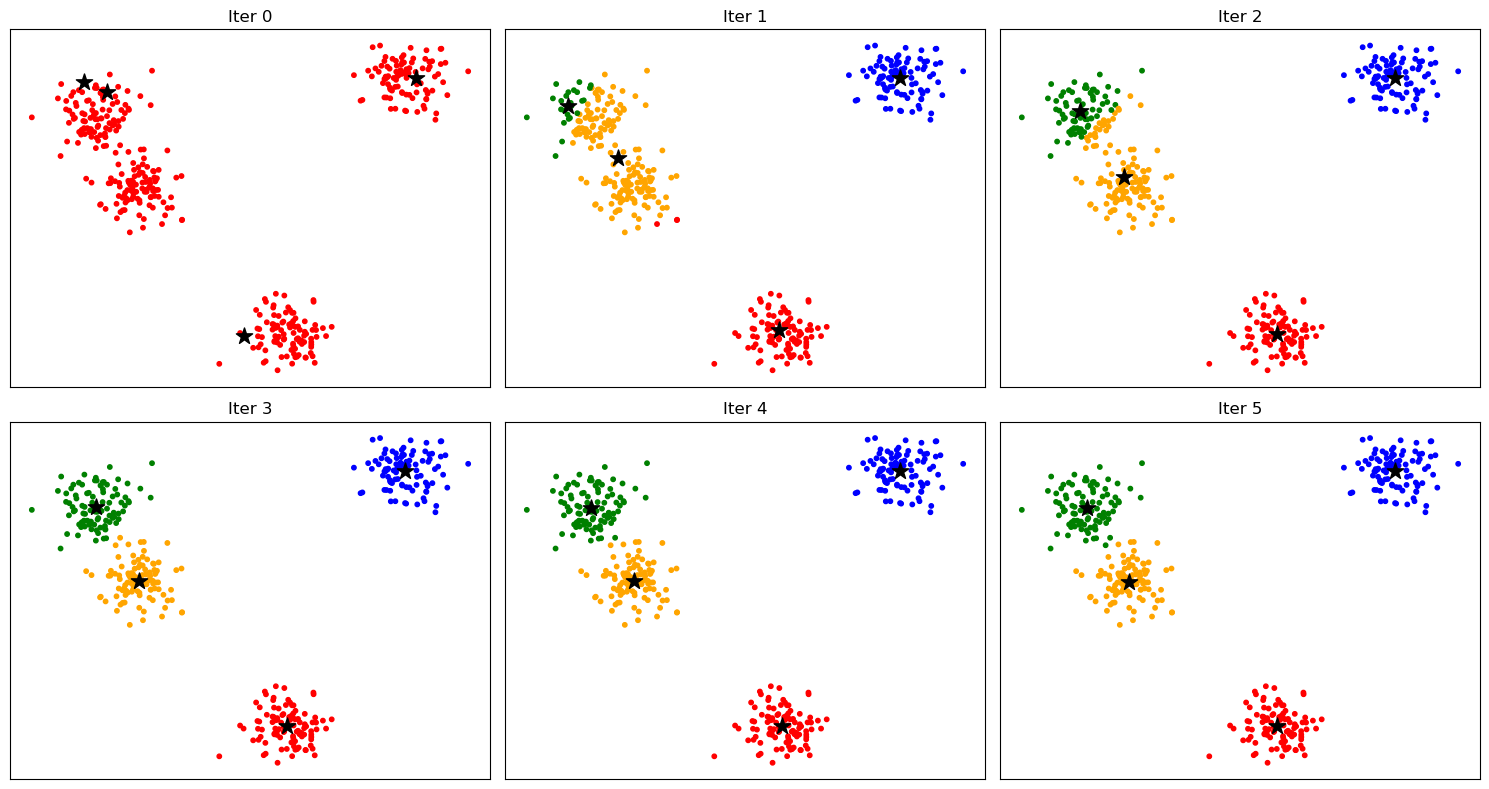

Final cost (WCSS): 2.03207738
Accuracy: 0.9950


In [3]:
# non-private single run
model = KMeansClustering(data, d=2, k=4, tol=1e-5, max_iter=5, private=False, seed=np.random.randint(0, 10000))
model.fit_and_plot_iterations()
print(f"Final cost (WCSS): {model.get_cost():.8f}")
labels = compute_accuracy(model.get_labels(), np.array([0]*100 + [1]*100 + [2]*100 + [3]*100), k=4)
accuracy = np.mean(labels == np.array([0]*100 + [1]*100 + [2]*100 + [3]*100))
print(f"Accuracy: {accuracy:.4f}")

In [4]:
# non-private accuracy across 100 runs
accuracies = []
for run in range(100):
    model = KMeansClustering(data, d=2, k=4, tol=1e-5, max_iter=5, private=False, seed=np.random.randint(0, 10000))
    model.fit_model(init_method=1) 
    corrected_labels = compute_accuracy(model.get_labels(), np.array([0]*100 + [1]*100 + [2]*100 + [3]*100), k=4)
    accuracy = np.mean(corrected_labels == np.array([0]*100 + [1]*100 + [2]*100 + [3]*100))
    accuracies.append(accuracy)
print(np.mean(accuracies))

Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Convergence Reached! Number of Iterations: 4
Maximum Number of Iterations Reached!
Convergence Reached! Number of Iterations: 4
Maximum Number of Iterations Reached!
Convergence Reached! Number of Iterations: 4
Convergence Reached! Number of Iterations: 4
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Convergence Reached! Number of Iterations: 4
Maximum Number of Iterations Reached!
Convergence Reached! Number of Iterations: 3
Maximum Number of Iterations Reached!
Convergence Reached! Number of Iterations: 5
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Convergence Reached! Number of Iterations: 3
Maximum Number of Iterations Reached!
Convergence Reached! Number of Iterations: 4
Convergence Reached! Number of Iterations: 5
Maximum Number of Iterations Reached!
Convergence Reached! Number of Iterations: 5
Convergence

Maximum Number of Iterations Reached!


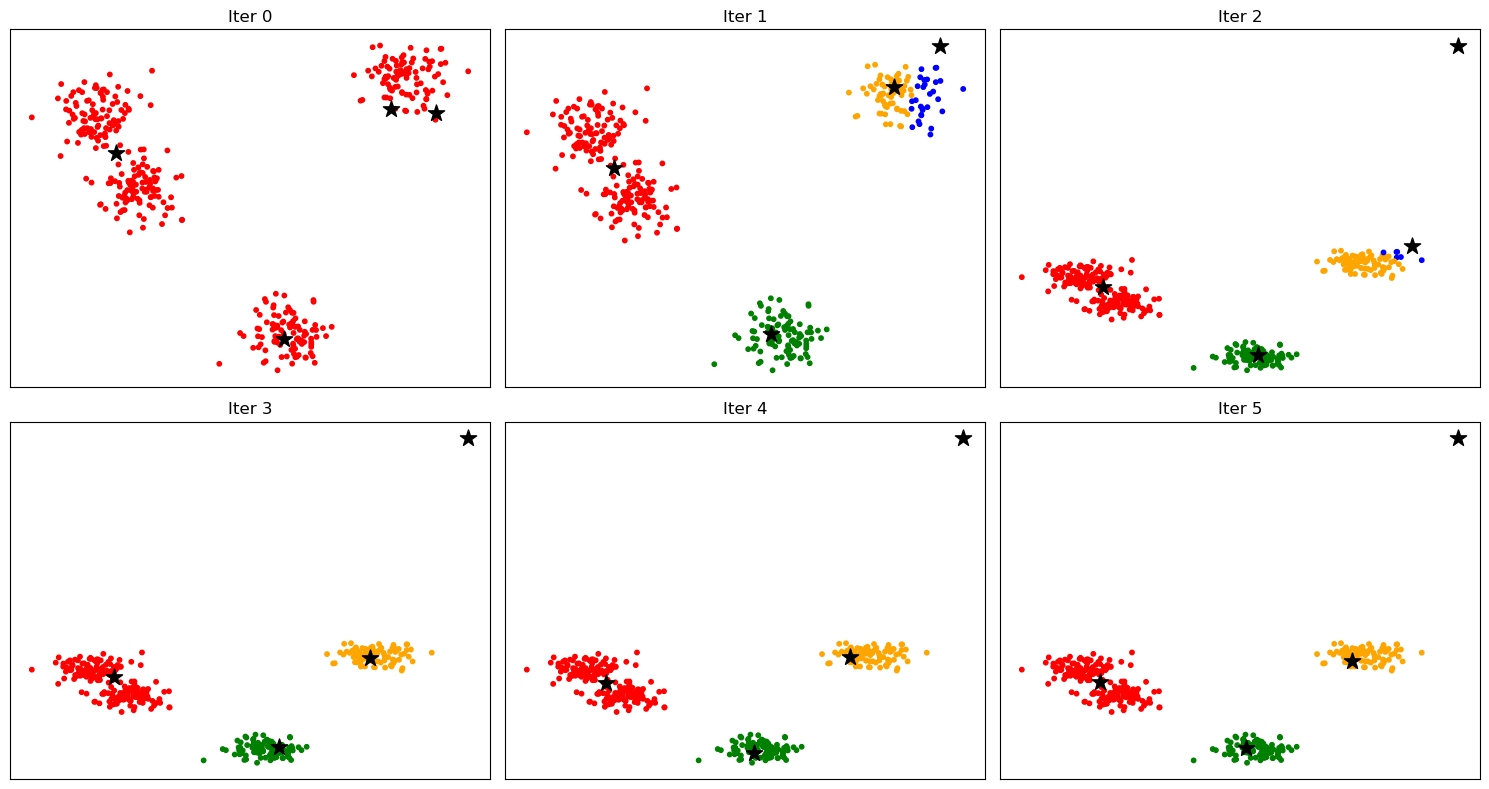

Final cost (WCSS): 5.13351115
Accuracy: 0.7500


In [5]:
# private single run: eps-dp
model_private = KMeansClustering(data, d=2, k=4, tol=1e-5, max_iter=5, private=True, private_mechanism='laplace', epsilon=5, seed=np.random.randint(0, 10000))
model_private.fit_and_plot_iterations()
print(f"Final cost (WCSS): {model_private.get_cost():.8f}")
corrected_pred_labels = compute_accuracy(model_private.get_labels(), np.array([0]*100 + [1]*100 + [2]*100 + [3]*100), k=4)
accuracy = np.mean(corrected_pred_labels == np.array([0]*100 + [1]*100 + [2]*100 + [3]*100))
print(f"Accuracy: {accuracy:.4f}")

Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Numb

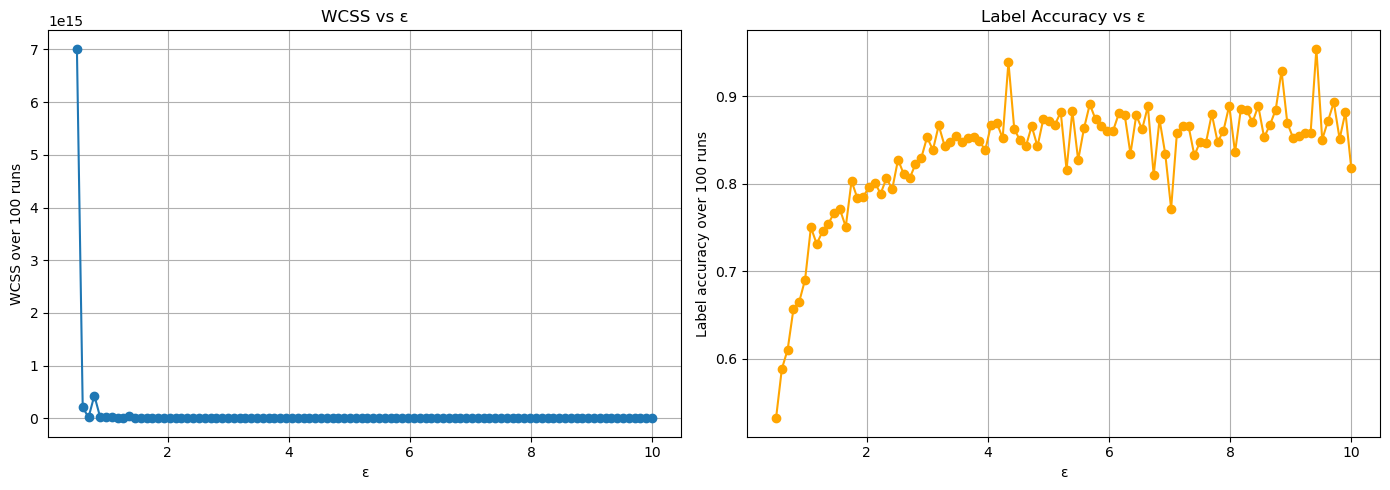

In [6]:
## e-dp accuracy over 100 runs
eps_values = np.linspace(0.5, 10, 100)  
mean_costs = []
mean_accuracies = []
true_labels = np.array([0]*100 + [1]*100 + [2]*100 + [3]*100)  

for eps in eps_values:
    
    # WCSS calculation
    costs = []
    for _ in range(100):
        seed = np.random.randint(0, 10000)
        model = KMeansClustering(data, d=2, k=4, tol=1e-5, max_iter=5,
                                 private=True, epsilon=eps, private_mechanism='laplace',  seed=np.random.randint(0, 10000))
        model.fit_model(init_method=1)
        cost = model.get_cost()
        costs.append(cost)
    mean_costs.append(np.mean(costs))

    # Accuracy calculation
    accuracies = []
    for _ in range(100):
        model = KMeansClustering(data, d=2, k=4, tol=1e-5, max_iter=5,
                                 private=True, epsilon=eps, private_mechanism='laplace', seed=np.random.randint(0, 10000))
        model.fit_model(init_method=1)
        pred_labels = model.get_labels()
        corrected_labels = compute_accuracy(pred_labels, true_labels, k=4)
        accuracy = np.mean(corrected_labels == true_labels)
        accuracies.append(accuracy)
    mean_accuracies.append(np.mean(accuracies))

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(eps_values, mean_costs, marker='o', linestyle='-')
axs[0].set_title("WCSS vs ε")
axs[0].set_xlabel("ε")
axs[0].set_ylabel("WCSS over 100 runs")
axs[0].grid(True)
axs[1].plot(eps_values, mean_accuracies, marker='o', color='orange')
axs[1].set_title("Label Accuracy vs ε")
axs[1].set_xlabel("ε")
axs[1].set_ylabel("Label accuracy over 100 runs")
axs[1].grid(True)
plt.tight_layout()
plt.show()

Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Numb

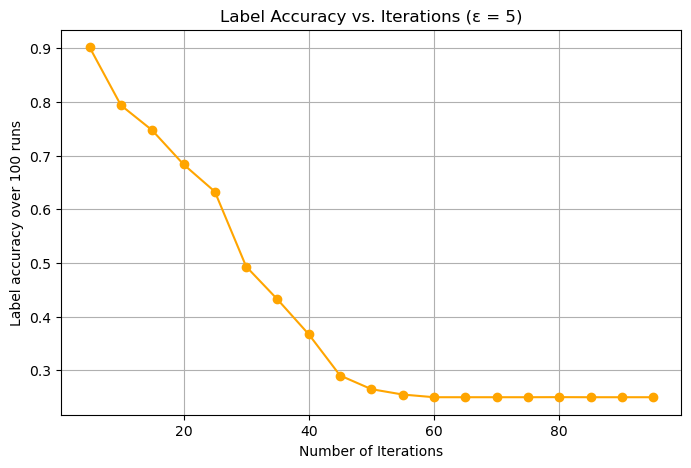

In [7]:
eps_fixed = 5
iterations_range = range(5, 100, 5)  
mean_accuracies_iter = []

true_labels = np.array([0]*100 + [1]*100 + [2]*100 + [3]*100)

for T in iterations_range:
    accuracies = []
    for run in range(100):
        model = KMeansClustering(data, d=2, k=4, tol=1e-5, max_iter=T,
                                 private=True, epsilon=eps_fixed, seed=np.random.randint(0, 10000))
        model.fit_model(init_method=1)
        pred_labels = model.get_labels()
        corrected_labels = compute_accuracy(pred_labels, true_labels, k=4)
        accuracy = np.mean(corrected_labels == true_labels)
        accuracies.append(accuracy)
    mean_acc = np.mean(accuracies)
    mean_accuracies_iter.append(mean_acc)
    print(f"Iterations: {T}, Mean Accuracy: {mean_acc:.4f}")

plt.figure(figsize=(8,5))
plt.plot(list(iterations_range), mean_accuracies_iter, marker='o', color='orange')
plt.xlabel("Number of Iterations")
plt.ylabel("Label accuracy over 100 runs")
plt.title(f"Label Accuracy vs. Iterations (ε = {eps_fixed})")
plt.grid(True)
plt.show()


Maximum Number of Iterations Reached!


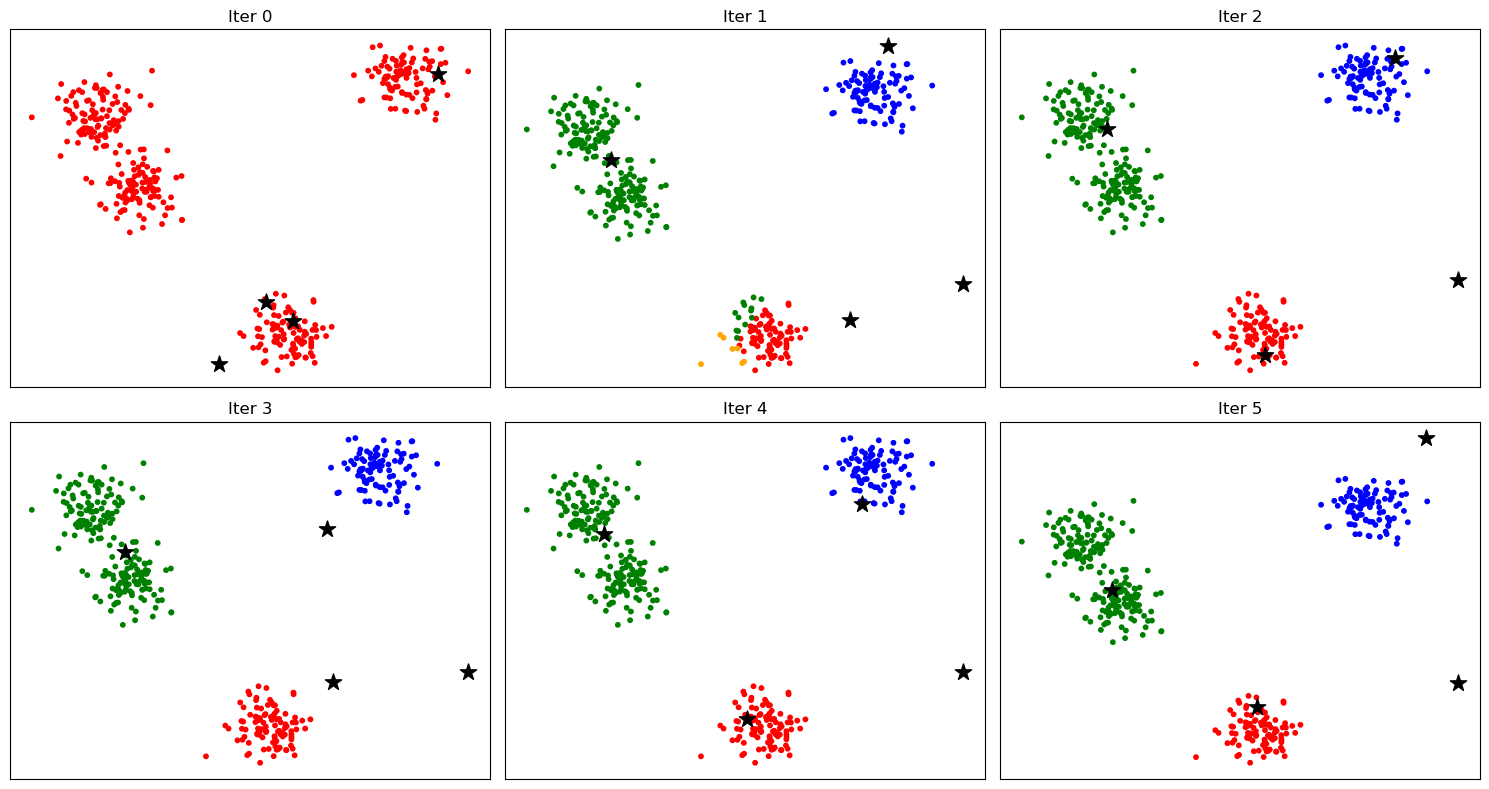

Final cost (WCSS): 13.54204026
Accuracy: 0.7500


In [8]:
# private single run: (e,delta)-dp
model_private = KMeansClustering(data, d=2, k=4, tol=1e-5, max_iter=5, private=True, private_mechanism='gaussian', epsilon=5, seed=np.random.randint(0, 10000))
model_private.fit_and_plot_iterations()
print(f"Final cost (WCSS): {model_private.get_cost():.8f}")

corrected_pred_labels = compute_accuracy(model_private.get_labels(), np.array([0]*100 + [1]*100 + [2]*100 + [3]*100), k=4)
accuracy = np.mean(corrected_pred_labels == np.array([0]*100 + [1]*100 + [2]*100 + [3]*100))
print(f"Accuracy: {accuracy:.4f}")

Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Number of Iterations Reached!
Maximum Numb

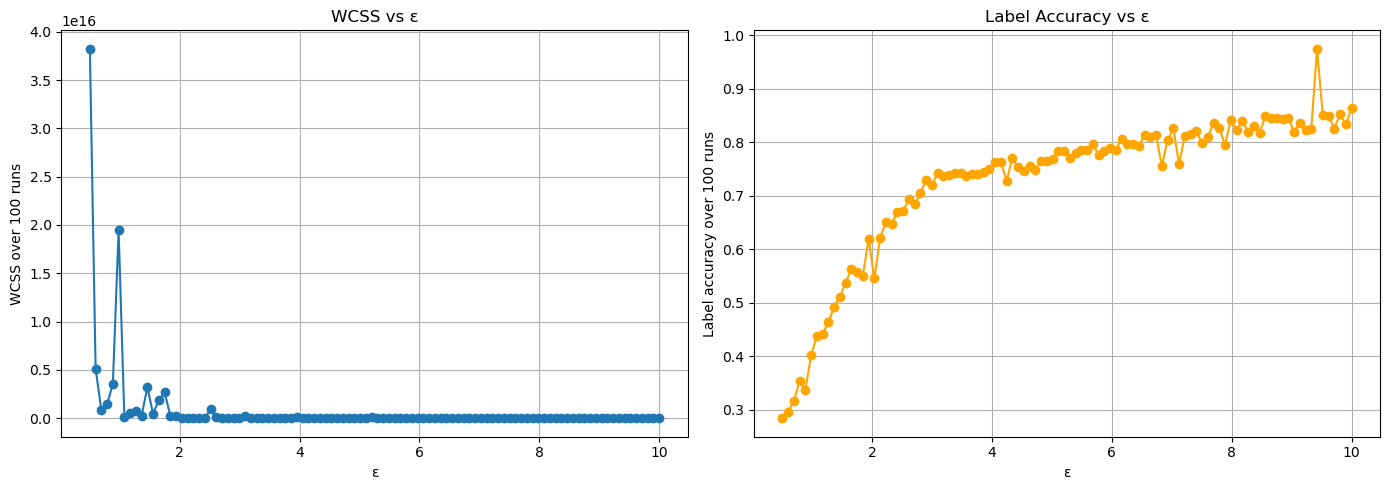

In [9]:
## e-dp accuracy over 100 runs
eps_values = np.linspace(0.5, 10, 100)  
mean_costs = []
mean_accuracies = []
true_labels = np.array([0]*100 + [1]*100 + [2]*100 + [3]*100)  

for eps in eps_values:
    
    # WCSS calculation
    costs = []
    for _ in range(100):
        seed = np.random.randint(0, 10000)
        model = KMeansClustering(data, d=2, k=4, tol=1e-5, max_iter=5,
                                 private=True, epsilon=eps, private_mechanism='gaussian',  seed=np.random.randint(0, 10000))
        model.fit_model(init_method=1)
        cost = model.get_cost()
        costs.append(cost)
    mean_costs.append(np.mean(costs))

    # Accuracy calculation
    accuracies = []
    for _ in range(100):
        model = KMeansClustering(data, d=2, k=4, tol=1e-5, max_iter=5,
                                 private=True, epsilon=eps, private_mechanism='gaussian', seed=np.random.randint(0, 10000))
        model.fit_model(init_method=1)
        pred_labels = model.get_labels()
        corrected_labels = compute_accuracy(pred_labels, true_labels, k=4)
        accuracy = np.mean(corrected_labels == true_labels)
        accuracies.append(accuracy)
    mean_accuracies.append(np.mean(accuracies))

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(eps_values, mean_costs, marker='o', linestyle='-')
axs[0].set_title("WCSS vs ε")
axs[0].set_xlabel("ε")
axs[0].set_ylabel("WCSS over 100 runs")
axs[0].grid(True)
axs[1].plot(eps_values, mean_accuracies, marker='o', color='orange')
axs[1].set_title("Label Accuracy vs ε")
axs[1].set_xlabel("ε")
axs[1].set_ylabel("Label accuracy over 100 runs")
axs[1].grid(True)
plt.tight_layout()
plt.show()